In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# train_dir = "/content/drive/MyDrive/Aryan_data/Malaria_Cells/training_set"
# test_dir = "/content/drive/MyDrive/Aryan_data/Malaria_Cells/testing_set"
# val_dir = "/content/drive/MyDrive/Aryan_data/Malaria_Cells/single_prediction"

In [ ]:
# !cp -r "/content/drive/MyDrive/Aryan_data/Malaria_Cells" "/content/Malaria_Cells"

In [1]:
import zipfile
import os

folder_name = "Aryan_data.zip"  # Change this to your actual ZIP file name
with zipfile.ZipFile(folder_name, 'r') as zip_ref:
    zip_ref.extractall("/content")  # Extract in Colab's working directory
os.remove(folder_name)  # Optional: Remove the ZIP file after extraction

In [7]:
train_dir = "/content/Aryan_data/Malaria_Cells/training_set"
test_dir = "/content/Aryan_data/Malaria_Cells/testing_set"
val_dir = "/content/Aryan_data/Malaria_Cells/single_prediction"

In [3]:
!pip install -U keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 7.4 MB/s eta 0:00:00


In [9]:
import os
import glob
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, AveragePooling2D, BatchNormalization, GlobalAveragePooling2D
import matplotlib.pyplot as plt
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [10]:
print("Train: ", os.listdir(train_dir))
print("Test: ", os.listdir(train_dir))

Train:  ['Parasitized', '.DS_Store', 'Uninfected']
Test:  ['Parasitized', '.DS_Store', 'Uninfected']


In [11]:
# List class labels (folder names)
class_labels = os.listdir(train_dir)
class_labels.sort()  # Sort to maintain consistent order

print("Classes in the dataset:", class_labels)

Classes in the dataset: ['.DS_Store', 'Parasitized', 'Uninfected']


In [12]:
# Create a dictionary to map class names to numerical labels
label_map = {class_name: idx for idx, class_name in enumerate(class_labels)}

print("Class Mapping:", label_map)

Class Mapping: {'.DS_Store': 0, 'Parasitized': 1, 'Uninfected': 2}


In [13]:
# Set image size
IMG_SIZE = 224

# Define class mapping (Only needed for train & test directories)
class_labels = {'Parasitized': 0, 'Uninfected': 1}

def load_images_from_directory(directory):
    images, labels = [], []

    subdirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]

    for class_name in subdirs:
        if class_name not in class_labels:
            print(f"Skipping unknown class folder: {class_name}")
            continue  # Skip unexpected folders

        class_path = os.path.join(directory, class_name)
        image_paths = glob.glob(os.path.join(class_path, "*.jpg")) + glob.glob(os.path.join(class_path, "*.png"))

        for img_path in image_paths:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            if img is None:
                print(f"Warning: Could not read {img_path}")
                continue

            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
            img = np.expand_dims(img, axis=-1)

            images.append(img)
            labels.append(class_labels[class_name])

    return np.array(images), np.array(labels)

def load_single_images(directory):
    """Loads images without requiring class subdirectories (For Validation)."""
    images = []
    image_paths = glob.glob(os.path.join(directory, "*.jpg")) + glob.glob(os.path.join(directory, "*.png"))

    for img_path in image_paths:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if img is None:
            print(f"Warning: Could not read {img_path}")
            continue

        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
        img = np.expand_dims(img, axis=-1)

        images.append(img)

    return np.array(images)

# ✅ Load training & testing (with subdirectories)
train_images, train_labels = load_images_from_directory(train_dir)
test_images, test_labels = load_images_from_directory(test_dir)

# ✅ Load validation (without subdirectories)
val_images = load_single_images(val_dir)

print("Train Shape:", train_images.shape)
print("Test Shape:", test_images.shape)
print("Validation Shape:", val_images.shape)  # No labels, just images

Train Shape: (27558, 224, 224, 1)
Test Shape: (15832, 224, 224, 1)
Validation Shape: (2, 224, 224, 1)


In [14]:
def build_model(hp):
    model = Sequential()

    # ✅ Start with Conv2D instead of AveragePooling
    model.add(Conv2D(
        filters=hp.Choice("layer_0_filters", [32, 64]),
        kernel_size=3,
        activation='relu',
        padding='same',
        input_shape=(IMG_SIZE, IMG_SIZE, 1)
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))

    # ✅ Tune Conv layers (max 3 layers)
    for i in range(hp.Int("Conv layers", min_value=2, max_value=3)):
        model.add(Conv2D(
            filters=hp.Choice(f"layer_{i}_filters", [32, 64, 128]),  # ✅ Keep stable filter sizes
            kernel_size=3,
            activation='relu',
            padding='same'
        ))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))

    model.add(Dropout(hp.Float("Dropout rate", 0.3, 0.5, step=0.1)))  # ✅ Increased Dropout for Regularization
    model.add(Flatten())

    # ✅ Reduce Dense Layer Complexity
    model.add(Dense(hp.Choice("Dense layer", [128, 256]), activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(1, activation='sigmoid'))  # ✅ Binary Classification Output

    # ✅ Only use Adam optimizer (RMSprop is unstable)
    model.compile(
        optimizer="adam",
        loss=keras.losses.BinaryCrossentropy(),
        metrics=['accuracy']
    )
    return model

In [25]:
# ✅ Increase max_trials for better tuning results
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Increase from 10 to 15
    directory='./hyperparameter_tuning',
    overwrite=True  # ✅ Ensure fresh tuning runs
)

# ✅ Improved Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1)
callbacks_list = [early_stopping, reduce_lr]

# ✅ Start tuning with a reduced batch size
tuner.search(
    train_images, train_labels,
    validation_data=(test_images, test_labels),
    epochs=5,
    batch_size=16,  # ✅ Reduced batch size (8)
    callbacks=callbacks_list
)

# ✅ Get best model and evaluate
best_model = tuner.get_best_models(num_models=1)[0]
test_loss, test_acc = best_model.evaluate(test_images, test_labels)
print(f"✅ Best Model Test Accuracy: {test_acc * 100:.2f}%")
print(f"❌ Best Model Test Loss: {test_loss:.4f}")

Trial 10 Complete [00h 01m 30s]
val_accuracy: 0.9529433846473694

Best val_accuracy So Far: 0.9558489322662354
Total elapsed time: 00h 17m 17s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


495/495 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9370 - loss: 0.1685
✅ Best Model Test Accuracy: 95.58%
❌ Best Model Test Loss: 0.1218


In [33]:
best_model.save("malaria_best_model.keras")

In [ ]:
from google.colab import files
files.download("malaria_best_model.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [34]:
from tensorflow.keras.models import load_model

# ✅ Load the trained model
model_path = "/content/malaria_best_model.keras"  # Update with actual path
model = load_model(model_path)

# ✅ Print Model Summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 42 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 32)          │          36,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,605,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,265,701 (20.09 MB)

 Trainable params: 1,755,041 (6.69 MB)

 Non-trainable params: 576 (2.25 KB)

 Optimizer params: 3,510,084 (13.39 MB)

In [35]:
import os
import cv2
import numpy as np

# ✅ Define Test Data Path
TEST_DIR = "/content/Aryan_data/Malaria_Cells/testing_set"  # Update path if needed

# ✅ Function to Load and Preprocess Images
def load_images(directory):
    images, labels = [], []
    class_labels = {'Parasitized': 0, 'Uninfected': 1}

    for class_name in class_labels.keys():
        class_path = os.path.join(directory, class_name)
        if not os.path.isdir(class_path):
            continue

        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue

            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue

            img = cv2.resize(img, (224, 224)) / 255.0  # Normalize
            images.append(np.expand_dims(img, axis=-1))
            labels.append(class_labels[class_name])

    return np.array(images), np.array(labels)

# ✅ Load Test Data
test_images, test_labels = load_images(TEST_DIR)
print(f"✅ Test Data Loaded: {test_images.shape}, {test_labels.shape}")

✅ Test Data Loaded: (15832, 224, 224, 1), (15832,)


495/495 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

🔍 First 10 Predictions vs Actual Labels:
Predictions: [0 0 0 0 0 0 0 0 1 0]
Actual Labels: [0 0 0 0 0 0 0 0 0 0]


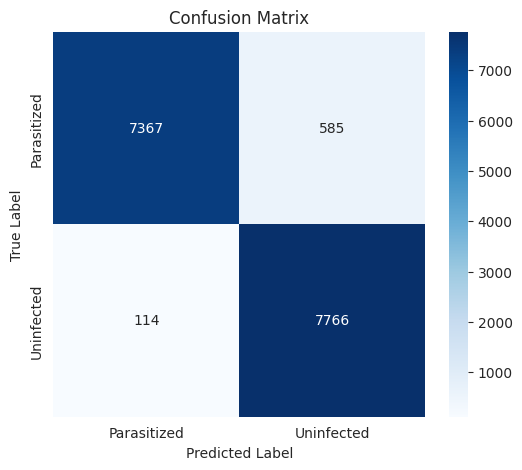


📌 Classification Report:

              precision    recall  f1-score   support

 Parasitized       0.98      0.93      0.95      7952
  Uninfected       0.93      0.99      0.96      7880

    accuracy                           0.96     15832
   macro avg       0.96      0.96      0.96     15832
weighted avg       0.96      0.96      0.96     15832


✅ Model Accuracy: 95.58%



In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# ✅ Define class labels
class_labels = ["Parasitized", "Uninfected"]

# ✅ Ensure `y_pred` is correctly shaped for binary classification
y_pred_probs = model.predict(test_images)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()  # Convert probabilities to binary (0 or 1)

# ✅ Print First 10 Predictions
print("\n🔍 First 10 Predictions vs Actual Labels:")
print("Predictions:", y_pred[:10])
print("Actual Labels:", test_labels[:10])

# ✅ Compute Confusion Matrix
cm = confusion_matrix(test_labels, y_pred)

# ✅ Normalize Confusion Matrix for better readability (Optional)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Convert to percentage

# ✅ Plot Confusion Matrix using Seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# ✅ Print Classification Report
print("\n📌 Classification Report:\n")
print(classification_report(test_labels, y_pred, target_names=class_labels))

# ✅ Print Model Accuracy
accuracy = accuracy_score(test_labels, y_pred)
print(f"\n✅ Model Accuracy: {accuracy * 100:.2f}%\n")



✅ Best Trial: 00
🏆 Best Validation Accuracy: 95.58%

📌 Best Hyperparameters:
  - layer_0_filters: 64
  - Conv layers: 3
  - layer_1_filters: 128
  - Dropout rate: 0.3
  - Dense layer: 256
  - layer_2_filters: 32


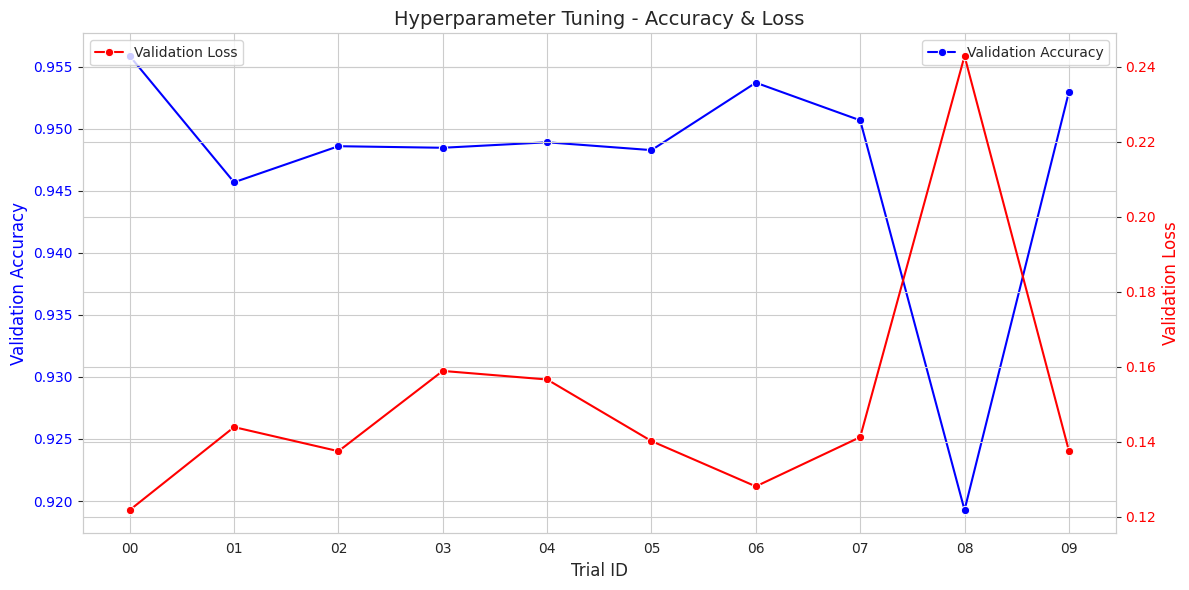

In [37]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# ✅ Define tuner directory path
tuner_dir = "/content/hyperparameter_tuning/untitled_project"

# ✅ Extract trial paths
trial_dirs = sorted(glob.glob(os.path.join(tuner_dir, "trial_*")))

trial_ids = []
val_accuracies = []
val_losses = []
hyperparams = {}

# ✅ Extract trial data
for trial_path in trial_dirs:
    trial_json_path = os.path.join(trial_path, "trial.json")

    if not os.path.exists(trial_json_path):
        continue

    # ✅ Load trial results
    with open(trial_json_path, "r") as f:
        trial_data = json.load(f)

    # ✅ Extract trial ID
    trial_id = trial_data.get("trial_id", trial_path.split("_")[-1])
    trial_ids.append(trial_id)

    # ✅ Extract validation accuracy & loss, ensuring they are floats
    try:
        val_acc = float(trial_data["metrics"]["metrics"]["val_accuracy"]["observations"][0]["value"][0])
        val_loss = float(trial_data["metrics"]["metrics"]["val_loss"]["observations"][0]["value"][0])
        val_accuracies.append(val_acc)
        val_losses.append(val_loss)
    except (KeyError, ValueError, IndexError) as e:
        print(f"⚠️ Skipping trial {trial_id} due to missing or invalid data: {e}")

    # ✅ Extract best hyperparameters
    if "hyperparameters" in trial_data:
        hyperparams[trial_id] = trial_data["hyperparameters"]["values"]

# ✅ Find the best trial based on max validation accuracy
if val_accuracies:
    best_trial_idx = np.argmax(val_accuracies)
    best_trial_id = trial_ids[best_trial_idx]
    best_hyperparams = hyperparams.get(best_trial_id, {})

    # ✅ Print best trial results in a clean format
    print("\n" + "="*50)
    print(f"✅ Best Trial: {best_trial_id}")
    print(f"🏆 Best Validation Accuracy: {val_accuracies[best_trial_idx] * 100:.2f}%")
    print("\n📌 Best Hyperparameters:")
    for key, value in best_hyperparams.items():
        print(f"  - {key}: {value}")
    print("="*50)

# ✅ Plot Accuracy & Loss in a Single Graph
sns.set_style("whitegrid")
fig, ax1 = plt.subplots(figsize=(12, 6))

# ✅ Plot Accuracy (Left Y-Axis)
ax1.set_xlabel("Trial ID", fontsize=12)
ax1.set_ylabel("Validation Accuracy", color="blue", fontsize=12)
sns.lineplot(x=trial_ids, y=val_accuracies, marker="o", color="blue", ax=ax1, label="Validation Accuracy")
ax1.tick_params(axis='y', labelcolor="blue")

# ✅ Create second Y-Axis for Loss
ax2 = ax1.twinx()
ax2.set_ylabel("Validation Loss", color="red", fontsize=12)
sns.lineplot(x=trial_ids, y=val_losses, marker="o", color="red", ax=ax2, label="Validation Loss")
ax2.tick_params(axis='y', labelcolor="red")

# ✅ Title and layout
plt.title("Hyperparameter Tuning - Accuracy & Loss", fontsize=14)
fig.tight_layout()

plt.show()